In [1]:
import numpy as np
import pandas as pd
import json

import warnings
warnings.filterwarnings("ignore")

from epilepsypcm.utils.outcome_params import node_location
from epilepsypcm.utils.make_df import make_df, get_df_list, concat_dfs
from epilepsypcm.models.base_models import *
from sklearn.metrics import auc
from sklearn.model_selection import StratifiedKFold, KFold


all_positive_patients = pd.read_csv("df_final.csv", sep = ',').reset_index(drop = True)

In [25]:
plot_roc = False
plot_pr = False

X_list = ["Channels", "SigResp", "N1RespAvg", "N1RespSDV", "N2RespAvg", "N2RespSDV", "P2RespAvg", "P2RespSDV", 
          "SigStim", "N1StimAvg", "N1StimSDV", "N2StimAvg", "N2StimSDV", "P2StimAvg", "P2StimSDV",
         "InDegree", "OutDegree", "EV", "Closeness"]

smote = False
max_depth = 20
rf, test_channels, y_pred, y_test, tpr, fpr, roc_thresholds, precision, recall = random_forest(all_positive_patients, X_list, max_depth, plot_roc, plot_pr, smote)

#getting model and stats
from sklearn.metrics import confusion_matrix

# Printing Metrics
optimal_thresh = roc_thresholds[np.argmax(tpr - fpr)]
print("Optimal roc threshold: ", optimal_thresh)
y_rounded = np.where(y_pred > optimal_thresh, 1, 0)

tn, fp, fn, tp = confusion_matrix(y_test, y_rounded).ravel()

print("Accuracy: ", (tp + tn)/(tp + fp + tn + fn))
print("Sensitivity: ", tp / (tp + fn))
print("Specificity: ", tn / (tn + fp))

Optimal roc threshold:  0.22
Accuracy:  0.7848101265822784
Sensitivity:  0.9285714285714286
Specificity:  0.7538461538461538


In [21]:
def rf_crossval(df, X_cols, test_size = 0.25):
    if "n1Zscore" in X_cols:
        df["n1Zscore"] = abs(df["n1Zscore"])
        df["n2Zscore"] = abs(df["n2Zscore"])
        df["p2Zscore"] = abs(df["p2Zscore"])

    X = df[X_cols]
    y = df[["outcome"]]["outcome"]
    
    X = X.drop(columns="Channels")

   # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=0, stratify = y)
    
    kf = StratifiedKFold(n_splits=10)
    
    rf = RandomForestClassifier(max_depth=20, random_state=0)
    tpr = []
    fpr = []
    thresholds = []
    aucs = []
    spec = []
    sens = []
    
    plt.figure(figsize=(10,10))
    
    i = 0
    mean_fpr = np.linspace(0, 1, 100)

    for train_index, test_index in kf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        y_pred = rf.fit(X_train, y_train).predict_proba(X_test)[:, 1]
        
        fpr_cv, tpr_cv, roc_thresholds_cv = metrics.roc_curve(y_test, y_pred, pos_label=1)
        
        auc_cv = auc(fpr_cv, tpr_cv)
        
        # ignore any with super low auc (buggy cause low data num)
        if auc_cv < 0.7:
            continue
        
        aucs.append(auc_cv)

        tpr.append(np.interp(mean_fpr, fpr_cv, tpr_cv))
        tpr[-1][0] = 0.0
        thresholds.append(roc_thresholds_cv)
        
        # Printing Metrics
        optimal_thresh = roc_thresholds[np.argmax(tpr_cv - fpr_cv)]
        y_rounded = np.where(y_pred > optimal_thresh, 1, 0)
        tn, fp, fn, tp = confusion_matrix(y_test, y_rounded).ravel()
        
        spec.append(tn / (tn + fp))
        sens.append(tp / (tp + fn))
        
        i += 1
        plt.plot(fpr_cv, tpr_cv, lw=1, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (i, auc_cv))
        plt.legend(loc='lower right')

        
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)
    plt.legend(loc='lower right')

    
    mean_tpr = np.mean(tpr, axis = 0)

    mean_auc = auc(mean_fpr, mean_tpr)
    
    std_auc = np.std(aucs)
    plt.plot(mean_fpr, mean_tpr, color='b',
             label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
             lw=2, alpha=.8)
    plt.legend(loc='lower right')

        
    print("AUCs: " ,aucs)
    print("Sensitivity: ", sens)
    print("Specificity: ", spec)
    
    std_tpr = np.std(tpr, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                     label=r'$\pm$ 1 std. dev.')

    plt.xlim([-0.01, 1.01])
    plt.ylim([-0.01, 1.01])
    plt.xlabel('False Positive Rate',fontsize=18)
    plt.ylabel('True Positive Rate',fontsize=18)
    plt.title('Cross-Validation ROC of RF Model',fontsize=18)
    plt.legend(loc="lower right", prop={'size': 10})
    
    plt.savefig("ROC.pdf")
    
    plt.show()
    
    return mean_fpr, mean_tpr
                    

AUCs:  [0.8237179487179488, 0.9134615384615384, 0.7596153846153846, 0.9666666666666667, 0.7884615384615384]
Sensitivity:  [0.8333333333333334, 0.3333333333333333, 0.5, 0.16666666666666666, 0.6]
Specificity:  [0.7307692307692307, 0.9615384615384616, 0.8461538461538461, 1.0, 0.7692307692307693]


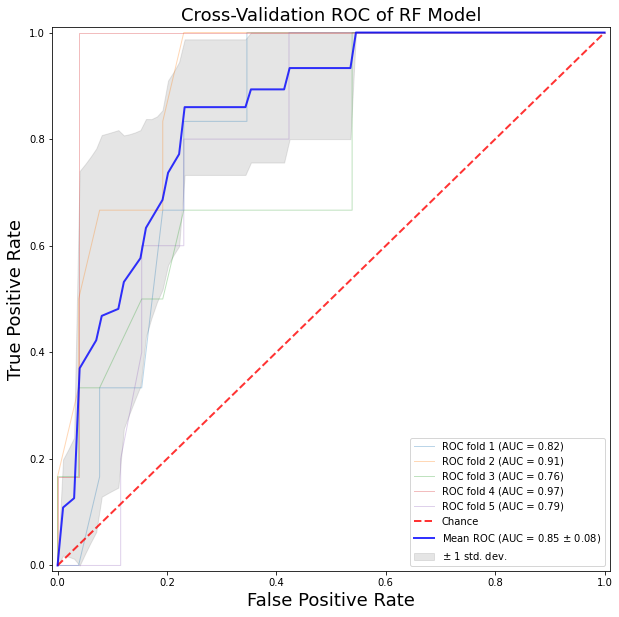

In [26]:
X_list = ["Channels", "SigResp", "N1RespAvg", "N1RespSDV", "N2RespAvg", "N2RespSDV", "P2RespAvg", "P2RespSDV", 
          "SigStim", "N1StimAvg", "N1StimSDV", "N2StimAvg", "N2StimSDV", "P2StimAvg", "P2StimSDV",
         "InDegree", "OutDegree", "EV", "Closeness"]

fpr_all, tpr_all = rf_crossval(all_positive_patients, X_list)   


In [27]:
def rf_crossval_noplots(df, X_cols, test_size = 0.25):
    if "n1Zscore" in X_cols:
        df["n1Zscore"] = abs(df["n1Zscore"])
        df["n2Zscore"] = abs(df["n2Zscore"])
        df["p2Zscore"] = abs(df["p2Zscore"])

    X = df[X_cols]
    y = df[["outcome"]]["outcome"]
    
    X = X.drop(columns="Channels")

   # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=0, stratify = y)
    
    kf = StratifiedKFold(n_splits=10)
    
    rf = RandomForestClassifier(max_depth=20, random_state=0)
    tpr = []
    fpr = []
    thresholds = []
    aucs = []
    spec = []
    sens = []
    
    #plt.figure(figsize=(10,10))
    
    i = 0
    mean_fpr = np.linspace(0, 1, 100)

    for train_index, test_index in kf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        y_pred = rf.fit(X_train, y_train).predict_proba(X_test)[:, 1]
        
        fpr_cv, tpr_cv, roc_thresholds_cv = metrics.roc_curve(y_test, y_pred, pos_label=1)
        
        auc_cv = auc(fpr_cv, tpr_cv)
        
        # ignore any with super low auc (buggy cause low data num)
        if auc_cv < 0.7:
            continue
        
        aucs.append(auc_cv)

        tpr.append(np.interp(mean_fpr, fpr_cv, tpr_cv))
        tpr[-1][0] = 0.0
        thresholds.append(roc_thresholds_cv)
        
        # Printing Metrics
        optimal_thresh = roc_thresholds[np.argmax(tpr_cv - fpr_cv)]
        y_rounded = np.where(y_pred > optimal_thresh, 1, 0)
        tn, fp, fn, tp = confusion_matrix(y_test, y_rounded).ravel()
        
        spec.append(tn / (tn + fp))
        sens.append(tp / (tp + fn))
        
        i += 1
       # plt.plot(fpr_cv, tpr_cv, lw=1, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (i, auc_cv))
       # plt.legend(loc='lower right')

        
    '''plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)
    plt.legend(loc='lower right')'''

    
    mean_tpr = np.mean(tpr, axis = 0)

    mean_auc = auc(mean_fpr, mean_tpr)
    
    std_auc = np.std(aucs)
    '''plt.plot(mean_fpr, mean_tpr, color='b',
             label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
             lw=2, alpha=.8)
    plt.legend(loc='lower right')
'''
        
    print("AUCs: " ,aucs)
    print("Sensitivity: ", sens)
    print("Specificity: ", spec)
    
    '''std_tpr = np.std(tpr, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                     label=r'$\pm$ 1 std. dev.')'''

    '''plt.xlim([-0.01, 1.01])
    plt.ylim([-0.01, 1.01])
    plt.xlabel('False Positive Rate',fontsize=18)
    plt.ylabel('True Positive Rate',fontsize=18)
    plt.title('Cross-Validation ROC of RF Model',fontsize=18)
    plt.legend(loc="lower right", prop={'size': 10})
    
    plt.savefig("ROC.pdf")'''
    
    '''plt.show()'''
    
    return mean_fpr, mean_tpr

In [28]:

'''getting fpr and tpr for NODAL'''
X_list = ["Channels", "N1RespAvg", "N1RespSDV", "N2RespAvg", "N2RespSDV", "P2RespAvg", "P2RespSDV", 
          "N1StimAvg", "N1StimSDV", "N2StimAvg", "N2StimSDV", "P2StimAvg", "P2StimSDV"]
nodal_fpr, nodal_tpr = rf_crossval_noplots(all_positive_patients, X_list)
#plt.plot(fpr, tpr, label = "Random Forest - Nodal Features, AUC = %0.2f" % auc(fpr, tpr))
#plt.legend(loc='lower right')

'''getting fpr and tpr for NETWORK'''
X_list = ["Channels","InDegree", "OutDegree", "Closeness"]
net_fpr, net_tpr = rf_crossval_noplots(all_positive_patients, X_list)
#plt.plot(fpr, tpr, label = "Random Forest - Network Features, AUC = %0.2f" % auc(fpr, tpr))
#plt.legend(loc='lower right')




AUCs:  [0.717948717948718, 0.8717948717948718, 1.0, 0.7384615384615384]
Sensitivity:  [0.6666666666666666, 0.3333333333333333, 0.16666666666666666, 0.2]
Specificity:  [0.7307692307692307, 0.8846153846153846, 1.0, 0.8461538461538461]
AUCs:  [0.8653846153846154, 0.7083333333333334, 0.717948717948718, 0.89]
Sensitivity:  [0.0, 0.6666666666666666, 0.16666666666666666, 0.0]
Specificity:  [1.0, 0.6923076923076923, 0.9615384615384616, 1.0]


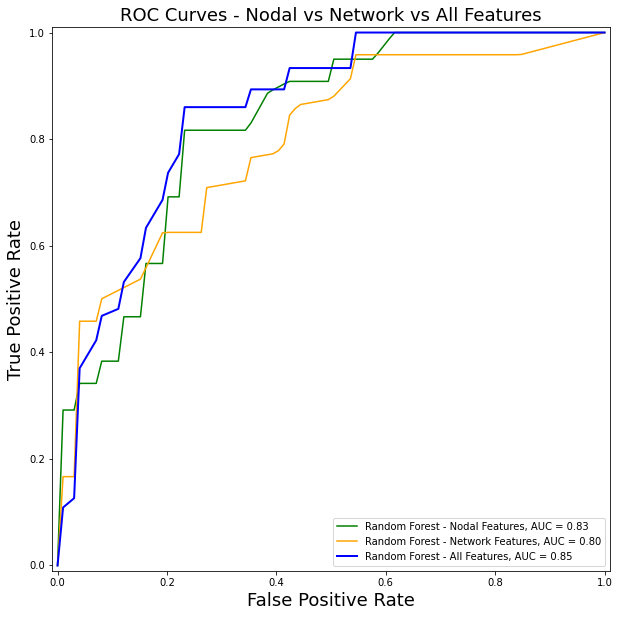

In [41]:
## Plotting Nodal vs Network vs All

plt.figure(figsize = (10,10))
plt.title("ROC Curves - Nodal vs Network vs All Features", fontsize = 18)
plt.xlabel("False Positive Rate", fontsize = 18)
plt.ylabel("True Positive Rate", fontsize = 18)
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])

plt.plot(nodal_fpr, nodal_tpr, label = "Random Forest - Nodal Features, AUC = %0.2f" % auc(nodal_fpr, nodal_tpr), color = 'g')
plt.plot(net_fpr, net_tpr, label = "Random Forest - Network Features, AUC = %0.2f" % auc(net_fpr, net_tpr), color = 'orange')
plt.plot(fpr_all, tpr_all, label = "Random Forest - All Features, AUC = %0.2f" % auc(fpr_all, tpr_all), color='b', lw=2)
plt.legend(loc='lower right')
plt.savefig("ROC_nodal_network_all.pdf")


<Figure size 432x288 with 0 Axes>